### Dataset Loading and testing

In [11]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split
#import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot
#currently installed theme will be used to
#set plot style if no arguments provided
jtplot.style()

#now load this dataset 
h5f = h5py.File('./datasets/s8_sio2tio2_v2.h5','r')
X = h5f['sizes'][:]
Y = h5f['spectrum'][:]




#get the ranges of the loaded data
num_layers = X.shape[1]
num_lpoints = Y.shape[1]
size_max = np.amax(X)
size_min = np.amin(X)
size_av = 0.5*(size_max + size_min)

#this information is not given in the dataset
lam_min = 300
lam_max = 1200
lams = np.linspace(lam_min, lam_max, num_lpoints)

# X = np.expand_dims(X, 1)
# #X = np.expand_dims(X, 3)
# Y = np.expand_dims(Y, 1)
# #Y = np.expand_dims(Y, 3)






#create a train - test split of the dataset
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=42)

# normalize inputs 
x_train = (x_train - 50)/20 
x_test = (x_test - 50)/20 

print("Dataset has been loaded")
print("x-train", x_train.shape)
print("x-test ", x_test.shape)
print("y-train", y_train.shape)
print("y-test ", y_test.shape)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Dataset has been loaded
x-train (60000, 8)
x-test  (40000, 8)
y-train (60000, 256)
y-test  (40000, 256)


#### Model Development

In [ ]:
from keras.utils import to_channels_first
x_train = to_channels_first(x_train)


In [12]:
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Reshape, UpSampling1D, Conv1D, Flatten, Activation
from keras.utils import np_utils, multi_gpu_model
from keras.regularizers import l2
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.layers import PReLU


from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

num_gpus = 2
gpu_list = ["gpu(%d)" % i for i in range(num_gpus)]



#define various models here
#naive percentage loss
def size_percent_loss(y_true, y_pred):
    y_true_a = 0.5*y_true*(size_max - size_min) + size_av
    y_pred_a = 0.5*y_pred*(size_max - size_min) + size_av
    y_err = np.abs(y_true_a - y_pred_a)/y_true_a
    y_err_f = K.flatten(y_err)
    return K.sum(y_err_f)

#naive percentage loss
def naive_percent_loss(y_true, y_pred):
    y_err = np.abs(y_true - y_pred)/y_true
    y_err_f = K.flatten(y_err)
    return K.sum(y_err_f)


#function to test performance on testset  
def calc_mre(y_true, y_pred):
    y_err = 100*np.abs(y_true - y_pred)/y_true
    return np.mean(y_err)

#function to test performance on testset  
def calc_mre_K(y_true, y_pred):
    y_err = 100*np.abs(y_true - y_pred)/y_true
    return K.mean(y_err)



def naiveploss_mgpu_model():
    # create model
    model = Sequential()
    model = multi_gpu_model(model, gpus=num_gpus)
    model.add(Dense(250, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='first' ))
    model.add(Dense(250, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='second' ))
    model.add(Dense(250, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='third' ))
    model.add(Dense(250, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='fourth' ))
    model.add(Dense(250, kernel_initializer='normal', name='last'))
    # Compile model
    model.compile(loss=naive_percent_loss, optimizer='adam', context = gpu_list)
    return model

def naiveploss_model():
    # create model
    model = Sequential()
    model.add(Dense(256, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='first' ))
    model.add(Dense(256, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='second' ))
    model.add(Dense(256, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='third' ))
    model.add(Dense(256, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='fourth' ))
    model.add(Dense(256, kernel_initializer='normal', name='last'))
    # Compile model
    model.compile(loss=naive_percent_loss, optimizer='adam', metrics=['accuracy'])
    return model

import timeit
#here we must have a function that calls the training routine n times and then gives avg and stddev 
# of the resulting figures
def net_performance(modelfunc, num_trials=3, batch_size=32, num_epochs=200, num_gpus=2):
    models = []
    train_err = np.ones(num_trials)
    test_err = np.ones(num_trials)
    val_err = np.ones(num_trials)
    train_time = np.ones(num_trials)
    for tnum in np.arange(num_trials):
        print("iteration: " + str(tnum + 1))
        model_curr = modelfunc()
        x_t, x_v, y_t, y_v = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
        start_time = timeit.default_timer()
        history = model_curr.fit(x_t, y_t,
                    batch_size=batch_size*num_gpus,
                    epochs=num_epochs, 
                    verbose=1,
                    validation_data=(x_v, y_v))
        train_time[tnum] = timeit.default_timer() - start_time
        models.append(model_curr)
        train_err[tnum] =  (100.0/num_lpoints)*history.history['loss'][-1]/(batch_size*num_gpus)
        val_err[tnum] =   (100.0/num_lpoints)*history.history['val_loss'][-1]/(batch_size*num_gpus)
        test_err[tnum] = calc_mre(y_test, models[tnum].predict(x_test))
    return train_err, val_err, test_err, train_time

#staging area for new models 
def plot_training_history(history, factor):
    loss, val_loss = history.history['loss'], history.history['val_loss']
    loss = np.asarray(loss)/(factor)
    val_loss = np.asarray(val_loss)/(factor)
    epochs = len(loss)
    
    fig, axs = plt.subplots(1,1, figsize=(5,2.5))
    axs.semilogy(np.arange(1, epochs + 1), loss, label='Train error')
    axs.semilogy(np.arange(1, epochs + 1), val_loss, label='Test error')
    axs.set_xlabel('Epoch number')
    #axs.set_ylim((0.4, 3))
    axs.set_xlim(left=1)
#     plt.yticks(np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0, 1.5, 2]), 
#                ('0.1', '0.2', '0.3', '0.4', '0.5',  '0.75', '1.0', '1.5', '2'))
    plt.yticks(np.array([0.5, 0.75, 1.0, 1.5, 2]), 
               ('0.5',  '0.75', '1.0', '1.5', '2'))
    axs.set_ylabel('MRE (%)')
    axs.legend(loc="best")
    fig.savefig("foo2.pdf", bbox_inches='tight')

from keras.utils import to_channels_first

def conv1d_lkyrelu():
    
    #gpu_list = ["gpu(%d)" % i for i in range(num_gpus)]
    
    # create model
    model = Sequential()
    
    model.add(Dense(256, input_dim=8, kernel_initializer='normal', 
                    name='first'))
    #model.add(BatchNormalization())
    #model.add(Activation('relu'))  
    model.add(PReLU(alpha_initializer='zeros', alpha_regularizer=None))
    
    model.add(Reshape((4, 64)))
    model.add(UpSampling1D(size=2))
    
    
    model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding='same', 
                     dilation_rate=1, 
                     kernel_initializer='normal'))
    model.add(PReLU(alpha_initializer='zeros', alpha_regularizer=None))
    
#     model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same', 
#                      dilation_rate=1, kernel_initializer='normal'))
#     model.add(PReLU(alpha_initializer='zeros', alpha_regularizer=None))
 
    model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same', 
                     dilation_rate=1, 
                     kernel_initializer='normal'))
    model.add(PReLU(alpha_initializer='zeros', alpha_regularizer=None))


#     model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same', 
#                      dilation_rate=1, kernel_initializer='normal'))
#     model.add(PReLU(alpha_initializer='ones', alpha_regularizer=None))   
    
#     model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same', 
#                      dilation_rate=1, kernel_initializer='normal'))
#     model.add(PReLU(alpha_initializer='ones', alpha_regularizer=None))  
    
    model.add(Flatten())
    # Compile model
    model.compile(loss=naive_percent_loss, optimizer='adam', metrics=[calc_mre_K])
    return model
    
    
def conv1d_model_bnorm():
    
    #gpu_list = ["gpu(%d)" % i for i in range(num_gpus)]
    
    # create model
    model = Sequential()
    
    model.add(Dense(256, input_dim=8, kernel_initializer='normal', 
                    name='first' ))
    #model.add(BatchNormalization())
    model.add(Activation('relu'))
    #model.add(Dropout(0.2))
    
    model.add(Reshape((4, 64)))
    model.add(UpSampling1D(size=2))
    
    model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding='same', 
                     dilation_rate=1, kernel_initializer='normal'))
    #model.add(BatchNormalization())
    model.add(Activation('relu'))
    #model.add(Dropout(0.2))
    #model.add(UpSampling1D(size=5))

    model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same', 
                     dilation_rate=1, kernel_initializer='normal'))
    model.add(Activation('relu'))
    #model.add(Dropout(0.3))
    
#     model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding='same', 
#                      dilation_rate=1, kernel_initializer='normal'))
#     model.add(Activation('relu'))   
#     model.add(Dropout(0.3))

#     model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same', 
#                      dilation_rate=1, kernel_initializer='normal'))
#     model.add(Activation('relu'))   
    
#     model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same', 
#                      dilation_rate=1, kernel_initializer='normal'))
#     model.add(Activation('relu'))  
    
#     model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same', 
#                      dilation_rate=1, kernel_initializer='normal'))
#     model.add(Activation('relu'))  
    
#     model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same', 
#                      dilation_rate=1, kernel_initializer='normal'))
#     model.add(Activation('relu'))  
    
    model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same', 
                     dilation_rate=1, kernel_initializer='normal'))
    model.add(Activation('relu'))    
    
    
    
    model.add(Flatten())
    # Compile model
#     if num_gpus == 1:
    model.compile(loss=naive_percent_loss, optimizer='adam', metrics=[calc_mre_K])
#     else:
#         model.compile(loss=naive_percent_loss, optimizer='adam', metrics=['accuracy'], context = gpu_list)
    
    
    return model    

def resnetb():
    model = Sequential()
    
    #first layer6
    model.add(Dense(256, input_dim=8, kernel_initializer='normal', 
                    name='first'))
    model.add(PReLU(alpha_initializer='zeros', alpha_regularizer=None))
    model.add(Reshape((8, 32)))
    
    
    #resnet block
#     model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same', 
#                      dilation_rate=1, 
#                      kernel_initializer='normal'))
#     model.add(PReLU(alpha_initializer='zeros', alpha_regularizer=None))
#     model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same', 
#                      dilation_rate=1, 
#                      kernel_initializer='normal'))
    
    
    
    #Last layer
    model.add(Flatten())
    
    #compile model
    model.compile(loss=naive_percent_loss, optimizer='adam', metrics=[calc_mre_K])
    
    return model


### Model testing

In [19]:
%autoreload
# import warnings
# warnings.filterwarnings('ignore')


# model = resnetb()
# #model = conv1d_lkyrelu()
# #model = conv1d_model_bnorm()
# #model = conv1d_model(1)

# #model = naiveploss_model()
# model.summary()

    
# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot

# #SVG(model_to_dot(model).create(prog='dot', format='svg'))
 


    
    
# import scnets as scn

# model = scn.resnet(in_size=8,     
#                    out_size=256,
#                    num_units=3,
#                    red_dim=16,
#                    batch_size=64,
#                    ker_size=3)

# model = scn.conv1dmodel(in_size=8, 
#         out_size=256,
#         batch_size=64,
#         c1_nf=64,
#         clayers=4,
#         ker_size=5)

model = scn.convprel(in_size=8, 
        out_size=256,
        batch_size=64,
        c1_nf=64,
        clayers=4,
        ker_size=3)

# model = scn.fullycon(in_size=8, 
#                      out_size=256, 
#                      batch_size=64,
#                      N_hidden=2, 
#                      N_neurons=256, 
#                      N_gpus=1)





# # from keras import optimizers
# # sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# #model.compile(loss=naive_percent_loss, optimizer='nadam', metrics=[calc_mre_K])

# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot
# from keras.utils.vis_utils import plot_model

# SVG(model_to_dot(model, show_shapes=False, show_layer_names=False).create(prog='dot', format='svg'))


# #plot_model(model, show_shapes=False, show_layer_names=False,  to_file='model_resnet.svg')



model.summary()    
    
    
x_t, x_v, y_t, y_v = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
# model = naiveploss_mgpu_model()
# model.summary()   
history = model.fit(x_t, y_t,
                    batch_size=64,
                    epochs=2000, 
                    verbose=1,
                    validation_data=(x_v, y_v))





# y_pred = model.predict(x_test)
# print(calc_mre(y_test, y_pred))



/home/hegder/anaconda3/envs/dp2/lib/python3.5/site-packages/keras/backend/mxnet_backend.py:89: UserWarning: MXNet Backend performs best with `channels_first` format. Using `channels_last` will significantly reduce performance due to the Transpose operations. For performance improvement, please use this API`keras.utils.to_channels_first(x_input)`to transform `channels_last` data to `channels_first` format and also please change the `image_data_format` in `keras.json` to `channels_first`.Note: `x_input` is a Numpy tensor or a list of Numpy tensorRefer to: https://github.com/awslabs/keras-apache-mxnet/tree/master/docs/mxnet_backend/performance_guide.md
  train_symbol = func(*args, **kwargs)
/home/hegder/anaconda3/envs/dp2/lib/python3.5/site-packages/keras/backend/mxnet_backend.py:92: UserWarning: MXNet Backend performs best with `channels_first` format. Using `channels_last` will significantly reduce performance due to the Transpose operations. For performance improvement, please use this

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first (Dense)                (None, 256)               2304      
_________________________________________________________________
p_re_lu_9 (PReLU)            (None, 256)               256       
_________________________________________________________________
Reshape1 (Reshape)           (None, 4, 64)             0         
_________________________________________________________________
Up1 (UpSampling1D)           (None, 8, 64)             0         
_________________________________________________________________
Conv1 (Conv1D)               (None, 8, 64)             12352     
_________________________________________________________________
p_re_lu_10 (PReLU)           (None, 8, 64)             512       
_________________________________________________________________
Conv2 (Conv1D)               (None, 8, 32)             6176      
__________

/home/hegder/anaconda3/envs/dp2/lib/python3.5/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.015625). Is this intended?
  force_init=force_init)


48000/48000 [==============================] - 3s 55us/step - loss: 2031.7968 - calc_mre_K: 12.4011 - val_loss: 846.2158 - val_calc_mre_K: 5.1718
Epoch 2/2000
48000/48000 [==============================] - 3s 55us/step - loss: 654.2782 - calc_mre_K: 3.9934 - val_loss: 525.1828 - val_calc_mre_K: 3.2097
Epoch 3/2000
48000/48000 [==============================] - 3s 52us/step - loss: 464.0548 - calc_mre_K: 2.8324 - val_loss: 431.2603 - val_calc_mre_K: 2.6357
Epoch 4/2000
48000/48000 [==============================] - 3s 53us/step - loss: 415.3811 - calc_mre_K: 2.5353 - val_loss: 381.9067 - val_calc_mre_K: 2.3341
Epoch 5/2000
48000/48000 [==============================] - 3s 53us/step - loss: 395.1123 - calc_mre_K: 2.4116 - val_loss: 423.0315 - val_calc_mre_K: 2.5854
Epoch 6/2000
48000/48000 [==============================] - 2s 51us/step - loss: 361.1197 - calc_mre_K: 2.2041 - val_loss: 346.1212 - val_calc_mre_K: 2.1153
Epoch 7/2000
48000/48000 [==============================] - 2s 51us/s

Epoch 53/2000
48000/48000 [==============================] - 3s 58us/step - loss: 173.2421 - calc_mre_K: 1.0574 - val_loss: 166.0553 - val_calc_mre_K: 1.0149
Epoch 54/2000
48000/48000 [==============================] - 3s 54us/step - loss: 172.1844 - calc_mre_K: 1.0509 - val_loss: 159.2861 - val_calc_mre_K: 0.9735
Epoch 55/2000
48000/48000 [==============================] - 2s 52us/step - loss: 171.0818 - calc_mre_K: 1.0442 - val_loss: 165.3388 - val_calc_mre_K: 1.0105
Epoch 56/2000
48000/48000 [==============================] - 3s 53us/step - loss: 173.4710 - calc_mre_K: 1.0588 - val_loss: 225.7608 - val_calc_mre_K: 1.3798
Epoch 57/2000
48000/48000 [==============================] - 3s 56us/step - loss: 164.7979 - calc_mre_K: 1.0058 - val_loss: 202.5197 - val_calc_mre_K: 1.2378
Epoch 58/2000
48000/48000 [==============================] - 3s 56us/step - loss: 170.6269 - calc_mre_K: 1.0414 - val_loss: 168.4014 - val_calc_mre_K: 1.0292
Epoch 59/2000
48000/48000 [=========================

Epoch 105/2000
48000/48000 [==============================] - 2s 51us/step - loss: 129.4538 - calc_mre_K: 0.7901 - val_loss: 134.9206 - val_calc_mre_K: 0.8246
Epoch 106/2000
48000/48000 [==============================] - 3s 57us/step - loss: 128.9063 - calc_mre_K: 0.7868 - val_loss: 126.2694 - val_calc_mre_K: 0.7717
Epoch 107/2000
48000/48000 [==============================] - 3s 57us/step - loss: 132.4297 - calc_mre_K: 0.8083 - val_loss: 138.4491 - val_calc_mre_K: 0.8462
Epoch 108/2000
48000/48000 [==============================] - 3s 56us/step - loss: 130.6471 - calc_mre_K: 0.7974 - val_loss: 124.5086 - val_calc_mre_K: 0.7610
Epoch 109/2000
48000/48000 [==============================] - 3s 55us/step - loss: 127.2583 - calc_mre_K: 0.7767 - val_loss: 126.1941 - val_calc_mre_K: 0.7713
Epoch 110/2000
48000/48000 [==============================] - 3s 54us/step - loss: 130.1550 - calc_mre_K: 0.7944 - val_loss: 131.2944 - val_calc_mre_K: 0.8025
Epoch 111/2000
48000/48000 [==================

48000/48000 [==============================] - 3s 54us/step - loss: 107.2713 - calc_mre_K: 0.6547 - val_loss: 105.9937 - val_calc_mre_K: 0.6478
Epoch 208/2000
48000/48000 [==============================] - 3s 59us/step - loss: 104.1053 - calc_mre_K: 0.6354 - val_loss: 116.0131 - val_calc_mre_K: 0.7091
Epoch 209/2000
48000/48000 [==============================] - 3s 55us/step - loss: 104.1980 - calc_mre_K: 0.6360 - val_loss: 113.6486 - val_calc_mre_K: 0.6946
Epoch 210/2000
48000/48000 [==============================] - 3s 53us/step - loss: 104.6845 - calc_mre_K: 0.6389 - val_loss: 98.5809 - val_calc_mre_K: 0.6025
Epoch 211/2000
48000/48000 [==============================] - 3s 56us/step - loss: 104.1774 - calc_mre_K: 0.6358 - val_loss: 98.9973 - val_calc_mre_K: 0.6051
Epoch 212/2000
48000/48000 [==============================] - 3s 56us/step - loss: 103.9606 - calc_mre_K: 0.6345 - val_loss: 98.1034 - val_calc_mre_K: 0.5996
Epoch 213/2000
48000/48000 [==============================] - 3s

Epoch 259/2000
48000/48000 [==============================] - 3s 58us/step - loss: 97.7796 - calc_mre_K: 0.5968 - val_loss: 95.2558 - val_calc_mre_K: 0.5822
Epoch 260/2000
48000/48000 [==============================] - 3s 57us/step - loss: 98.3614 - calc_mre_K: 0.6004 - val_loss: 101.9461 - val_calc_mre_K: 0.6231
Epoch 261/2000
48000/48000 [==============================] - 3s 61us/step - loss: 98.9988 - calc_mre_K: 0.6042 - val_loss: 93.9266 - val_calc_mre_K: 0.5741
Epoch 262/2000
48000/48000 [==============================] - 3s 55us/step - loss: 98.5042 - calc_mre_K: 0.6012 - val_loss: 106.2772 - val_calc_mre_K: 0.6496
Epoch 263/2000
48000/48000 [==============================] - 3s 57us/step - loss: 98.7353 - calc_mre_K: 0.6026 - val_loss: 93.3907 - val_calc_mre_K: 0.5708
Epoch 264/2000
48000/48000 [==============================] - 3s 57us/step - loss: 99.5590 - calc_mre_K: 0.6077 - val_loss: 102.1510 - val_calc_mre_K: 0.6243
Epoch 265/2000
48000/48000 [===========================

48000/48000 [==============================] - 3s 58us/step - loss: 94.7157 - calc_mre_K: 0.5781 - val_loss: 97.2685 - val_calc_mre_K: 0.5945
Epoch 312/2000
48000/48000 [==============================] - 3s 55us/step - loss: 94.9409 - calc_mre_K: 0.5795 - val_loss: 92.7366 - val_calc_mre_K: 0.5668
Epoch 313/2000
48000/48000 [==============================] - 3s 53us/step - loss: 95.1319 - calc_mre_K: 0.5806 - val_loss: 97.1883 - val_calc_mre_K: 0.5940
Epoch 314/2000
48000/48000 [==============================] - 3s 58us/step - loss: 94.1500 - calc_mre_K: 0.5746 - val_loss: 91.8530 - val_calc_mre_K: 0.5614
Epoch 315/2000
48000/48000 [==============================] - 3s 55us/step - loss: 95.3901 - calc_mre_K: 0.5822 - val_loss: 90.1071 - val_calc_mre_K: 0.5508
Epoch 316/2000
48000/48000 [==============================] - 3s 58us/step - loss: 93.4605 - calc_mre_K: 0.5704 - val_loss: 89.9605 - val_calc_mre_K: 0.5498
Epoch 317/2000
48000/48000 [==============================] - 3s 54us/ste

48000/48000 [==============================] - 3s 55us/step - loss: 86.1281 - calc_mre_K: 0.5257 - val_loss: 81.7868 - val_calc_mre_K: 0.4999
Epoch 416/2000
48000/48000 [==============================] - 3s 55us/step - loss: 87.3378 - calc_mre_K: 0.5331 - val_loss: 87.1821 - val_calc_mre_K: 0.5329
Epoch 417/2000
48000/48000 [==============================] - 3s 56us/step - loss: 85.7697 - calc_mre_K: 0.5235 - val_loss: 84.2322 - val_calc_mre_K: 0.5148
Epoch 418/2000
48000/48000 [==============================] - 3s 53us/step - loss: 86.9440 - calc_mre_K: 0.5307 - val_loss: 80.7191 - val_calc_mre_K: 0.4934
Epoch 419/2000
48000/48000 [==============================] - 3s 57us/step - loss: 85.7107 - calc_mre_K: 0.5231 - val_loss: 91.9072 - val_calc_mre_K: 0.5617
Epoch 420/2000
48000/48000 [==============================] - 3s 57us/step - loss: 87.1697 - calc_mre_K: 0.5320 - val_loss: 83.1460 - val_calc_mre_K: 0.5082
Epoch 421/2000
48000/48000 [==============================] - 3s 62us/ste

48000/48000 [==============================] - 3s 54us/step - loss: 82.1966 - calc_mre_K: 0.5017 - val_loss: 83.0163 - val_calc_mre_K: 0.5074
Epoch 520/2000
48000/48000 [==============================] - 3s 53us/step - loss: 83.3114 - calc_mre_K: 0.5085 - val_loss: 85.7307 - val_calc_mre_K: 0.5240
Epoch 521/2000
48000/48000 [==============================] - 3s 54us/step - loss: 81.4254 - calc_mre_K: 0.4970 - val_loss: 78.6196 - val_calc_mre_K: 0.4805
Epoch 522/2000
48000/48000 [==============================] - 3s 58us/step - loss: 82.6848 - calc_mre_K: 0.5047 - val_loss: 79.9891 - val_calc_mre_K: 0.4889
Epoch 523/2000
48000/48000 [==============================] - 3s 54us/step - loss: 85.8060 - calc_mre_K: 0.5237 - val_loss: 83.4820 - val_calc_mre_K: 0.5102
Epoch 524/2000
48000/48000 [==============================] - 3s 54us/step - loss: 81.4702 - calc_mre_K: 0.4973 - val_loss: 84.0198 - val_calc_mre_K: 0.5135
Epoch 525/2000
48000/48000 [==============================] - 3s 54us/ste

48000/48000 [==============================] - 3s 55us/step - loss: 80.0478 - calc_mre_K: 0.4886 - val_loss: 79.0295 - val_calc_mre_K: 0.4830
Epoch 624/2000
48000/48000 [==============================] - 3s 54us/step - loss: 79.2394 - calc_mre_K: 0.4836 - val_loss: 79.8674 - val_calc_mre_K: 0.4882
Epoch 625/2000
48000/48000 [==============================] - 3s 53us/step - loss: 80.7100 - calc_mre_K: 0.4926 - val_loss: 75.9482 - val_calc_mre_K: 0.4642
Epoch 626/2000
48000/48000 [==============================] - 3s 57us/step - loss: 80.7827 - calc_mre_K: 0.4931 - val_loss: 81.3494 - val_calc_mre_K: 0.4972
Epoch 627/2000
48000/48000 [==============================] - 3s 54us/step - loss: 79.2760 - calc_mre_K: 0.4839 - val_loss: 79.6280 - val_calc_mre_K: 0.4867
Epoch 628/2000
48000/48000 [==============================] - 3s 59us/step - loss: 80.1940 - calc_mre_K: 0.4895 - val_loss: 80.0756 - val_calc_mre_K: 0.4894
Epoch 629/2000
48000/48000 [==============================] - 3s 58us/ste

48000/48000 [==============================] - 3s 58us/step - loss: 78.6627 - calc_mre_K: 0.4801 - val_loss: 84.8342 - val_calc_mre_K: 0.5185
Epoch 728/2000
48000/48000 [==============================] - 3s 59us/step - loss: 77.9144 - calc_mre_K: 0.4756 - val_loss: 80.8966 - val_calc_mre_K: 0.4944
Epoch 729/2000
48000/48000 [==============================] - 3s 55us/step - loss: 77.9505 - calc_mre_K: 0.4758 - val_loss: 73.6831 - val_calc_mre_K: 0.4503
Epoch 730/2000
48000/48000 [==============================] - 3s 60us/step - loss: 78.3226 - calc_mre_K: 0.4780 - val_loss: 75.4109 - val_calc_mre_K: 0.4609
Epoch 731/2000
48000/48000 [==============================] - 3s 64us/step - loss: 78.4290 - calc_mre_K: 0.4787 - val_loss: 75.1637 - val_calc_mre_K: 0.4594
Epoch 732/2000
48000/48000 [==============================] - 3s 56us/step - loss: 78.0997 - calc_mre_K: 0.4767 - val_loss: 77.6759 - val_calc_mre_K: 0.4747
Epoch 733/2000
48000/48000 [==============================] - 3s 58us/ste

48000/48000 [==============================] - 3s 55us/step - loss: 76.7612 - calc_mre_K: 0.4685 - val_loss: 74.3267 - val_calc_mre_K: 0.4543
Epoch 832/2000
48000/48000 [==============================] - 3s 55us/step - loss: 76.7138 - calc_mre_K: 0.4682 - val_loss: 77.8206 - val_calc_mre_K: 0.4756
Epoch 833/2000
48000/48000 [==============================] - 3s 55us/step - loss: 76.5893 - calc_mre_K: 0.4675 - val_loss: 79.3091 - val_calc_mre_K: 0.4847
Epoch 834/2000
48000/48000 [==============================] - 3s 55us/step - loss: 77.0921 - calc_mre_K: 0.4705 - val_loss: 83.1803 - val_calc_mre_K: 0.5084
Epoch 835/2000
48000/48000 [==============================] - 3s 57us/step - loss: 76.5175 - calc_mre_K: 0.4670 - val_loss: 82.1222 - val_calc_mre_K: 0.5019
Epoch 836/2000
48000/48000 [==============================] - 3s 56us/step - loss: 77.1910 - calc_mre_K: 0.4711 - val_loss: 76.9383 - val_calc_mre_K: 0.4702
Epoch 837/2000
48000/48000 [==============================] - 3s 60us/ste

48000/48000 [==============================] - 3s 52us/step - loss: 75.3706 - calc_mre_K: 0.4600 - val_loss: 74.5149 - val_calc_mre_K: 0.4554
Epoch 936/2000
48000/48000 [==============================] - 3s 55us/step - loss: 75.2933 - calc_mre_K: 0.4596 - val_loss: 76.3564 - val_calc_mre_K: 0.4667
Epoch 937/2000
48000/48000 [==============================] - 3s 55us/step - loss: 75.4620 - calc_mre_K: 0.4606 - val_loss: 78.1654 - val_calc_mre_K: 0.4777
Epoch 938/2000
48000/48000 [==============================] - 3s 54us/step - loss: 75.5151 - calc_mre_K: 0.4609 - val_loss: 76.8468 - val_calc_mre_K: 0.4697
Epoch 939/2000
48000/48000 [==============================] - 3s 53us/step - loss: 75.3785 - calc_mre_K: 0.4601 - val_loss: 73.0442 - val_calc_mre_K: 0.4464
Epoch 940/2000
48000/48000 [==============================] - 3s 56us/step - loss: 75.3814 - calc_mre_K: 0.4601 - val_loss: 74.2858 - val_calc_mre_K: 0.4540
Epoch 941/2000
48000/48000 [==============================] - 3s 57us/ste

48000/48000 [==============================] - 3s 56us/step - loss: 72.7421 - calc_mre_K: 0.4440 - val_loss: 77.6350 - val_calc_mre_K: 0.4745
Epoch 1040/2000
48000/48000 [==============================] - 3s 59us/step - loss: 73.3676 - calc_mre_K: 0.4478 - val_loss: 73.7999 - val_calc_mre_K: 0.4510
Epoch 1041/2000
48000/48000 [==============================] - 3s 57us/step - loss: 73.9401 - calc_mre_K: 0.4513 - val_loss: 72.4538 - val_calc_mre_K: 0.4428
Epoch 1042/2000
48000/48000 [==============================] - 3s 57us/step - loss: 73.8023 - calc_mre_K: 0.4505 - val_loss: 75.2394 - val_calc_mre_K: 0.4598
Epoch 1043/2000
48000/48000 [==============================] - 3s 55us/step - loss: 73.3188 - calc_mre_K: 0.4475 - val_loss: 75.0123 - val_calc_mre_K: 0.4584
Epoch 1044/2000
48000/48000 [==============================] - 3s 56us/step - loss: 73.0661 - calc_mre_K: 0.4460 - val_loss: 71.2796 - val_calc_mre_K: 0.4356
Epoch 1045/2000
48000/48000 [==============================] - 3s 55

Epoch 1091/2000
48000/48000 [==============================] - 3s 55us/step - loss: 72.9361 - calc_mre_K: 0.4452 - val_loss: 70.0537 - val_calc_mre_K: 0.4281
Epoch 1092/2000
48000/48000 [==============================] - 3s 58us/step - loss: 72.0126 - calc_mre_K: 0.4395 - val_loss: 71.7583 - val_calc_mre_K: 0.4385
Epoch 1093/2000
48000/48000 [==============================] - 3s 55us/step - loss: 72.6551 - calc_mre_K: 0.4435 - val_loss: 72.0408 - val_calc_mre_K: 0.4403
Epoch 1094/2000
48000/48000 [==============================] - 3s 56us/step - loss: 72.3395 - calc_mre_K: 0.4415 - val_loss: 72.0190 - val_calc_mre_K: 0.4401
Epoch 1095/2000
48000/48000 [==============================] - 3s 54us/step - loss: 73.2035 - calc_mre_K: 0.4468 - val_loss: 75.2397 - val_calc_mre_K: 0.4598
Epoch 1096/2000
48000/48000 [==============================] - 3s 56us/step - loss: 72.1818 - calc_mre_K: 0.4406 - val_loss: 72.1392 - val_calc_mre_K: 0.4409
Epoch 1097/2000
48000/48000 [=======================

Epoch 1143/2000
48000/48000 [==============================] - 3s 57us/step - loss: 71.7588 - calc_mre_K: 0.4380 - val_loss: 69.8626 - val_calc_mre_K: 0.4270
Epoch 1144/2000
48000/48000 [==============================] - 3s 54us/step - loss: 71.6038 - calc_mre_K: 0.4370 - val_loss: 71.8483 - val_calc_mre_K: 0.4391
Epoch 1145/2000
48000/48000 [==============================] - 3s 56us/step - loss: 72.3257 - calc_mre_K: 0.4414 - val_loss: 72.0287 - val_calc_mre_K: 0.4402
Epoch 1146/2000
48000/48000 [==============================] - 3s 53us/step - loss: 71.6514 - calc_mre_K: 0.4373 - val_loss: 76.0672 - val_calc_mre_K: 0.4649
Epoch 1147/2000
48000/48000 [==============================] - 3s 54us/step - loss: 71.7718 - calc_mre_K: 0.4381 - val_loss: 69.7897 - val_calc_mre_K: 0.4265
Epoch 1148/2000
48000/48000 [==============================] - 3s 57us/step - loss: 71.1029 - calc_mre_K: 0.4340 - val_loss: 69.7249 - val_calc_mre_K: 0.4261
Epoch 1149/2000
48000/48000 [=======================

Epoch 1195/2000
48000/48000 [==============================] - 3s 54us/step - loss: 70.7482 - calc_mre_K: 0.4318 - val_loss: 72.1709 - val_calc_mre_K: 0.4411
Epoch 1196/2000
48000/48000 [==============================] - 3s 54us/step - loss: 71.3808 - calc_mre_K: 0.4357 - val_loss: 69.0024 - val_calc_mre_K: 0.4217
Epoch 1197/2000
48000/48000 [==============================] - 3s 54us/step - loss: 71.0520 - calc_mre_K: 0.4337 - val_loss: 81.9505 - val_calc_mre_K: 0.5008
Epoch 1198/2000
48000/48000 [==============================] - 3s 53us/step - loss: 71.9719 - calc_mre_K: 0.4393 - val_loss: 71.6844 - val_calc_mre_K: 0.4381
Epoch 1199/2000
48000/48000 [==============================] - 2s 50us/step - loss: 71.0513 - calc_mre_K: 0.4337 - val_loss: 72.7855 - val_calc_mre_K: 0.4448
Epoch 1200/2000
48000/48000 [==============================] - 3s 54us/step - loss: 71.2043 - calc_mre_K: 0.4346 - val_loss: 71.8019 - val_calc_mre_K: 0.4388
Epoch 1201/2000
48000/48000 [=======================

Epoch 1247/2000
48000/48000 [==============================] - 3s 54us/step - loss: 71.0308 - calc_mre_K: 0.4335 - val_loss: 70.4263 - val_calc_mre_K: 0.4304
Epoch 1248/2000
48000/48000 [==============================] - 3s 54us/step - loss: 70.5298 - calc_mre_K: 0.4305 - val_loss: 69.0273 - val_calc_mre_K: 0.4219
Epoch 1249/2000
48000/48000 [==============================] - 3s 55us/step - loss: 70.7385 - calc_mre_K: 0.4318 - val_loss: 72.6243 - val_calc_mre_K: 0.4438
Epoch 1250/2000
48000/48000 [==============================] - 3s 53us/step - loss: 70.5457 - calc_mre_K: 0.4306 - val_loss: 72.8127 - val_calc_mre_K: 0.4450
Epoch 1251/2000
48000/48000 [==============================] - 3s 54us/step - loss: 70.3736 - calc_mre_K: 0.4295 - val_loss: 71.0937 - val_calc_mre_K: 0.4345
Epoch 1252/2000
48000/48000 [==============================] - 3s 53us/step - loss: 70.9644 - calc_mre_K: 0.4331 - val_loss: 69.4244 - val_calc_mre_K: 0.4243
Epoch 1253/2000
48000/48000 [=======================

Epoch 1299/2000
48000/48000 [==============================] - 3s 55us/step - loss: 71.3794 - calc_mre_K: 0.4357 - val_loss: 77.0868 - val_calc_mre_K: 0.4711
Epoch 1300/2000
48000/48000 [==============================] - 3s 54us/step - loss: 69.6787 - calc_mre_K: 0.4253 - val_loss: 69.4070 - val_calc_mre_K: 0.4242
Epoch 1301/2000
48000/48000 [==============================] - 3s 62us/step - loss: 70.4443 - calc_mre_K: 0.4300 - val_loss: 70.1432 - val_calc_mre_K: 0.4287
Epoch 1302/2000
48000/48000 [==============================] - 3s 58us/step - loss: 69.9951 - calc_mre_K: 0.4272 - val_loss: 68.7678 - val_calc_mre_K: 0.4203
Epoch 1303/2000
48000/48000 [==============================] - 3s 56us/step - loss: 70.1724 - calc_mre_K: 0.4283 - val_loss: 71.0268 - val_calc_mre_K: 0.4341
Epoch 1304/2000
48000/48000 [==============================] - 3s 54us/step - loss: 70.2740 - calc_mre_K: 0.4289 - val_loss: 76.4377 - val_calc_mre_K: 0.4672
Epoch 1305/2000
48000/48000 [=======================

Epoch 1351/2000
48000/48000 [==============================] - 3s 56us/step - loss: 69.2826 - calc_mre_K: 0.4229 - val_loss: 71.8987 - val_calc_mre_K: 0.4394
Epoch 1352/2000
48000/48000 [==============================] - 3s 58us/step - loss: 69.5693 - calc_mre_K: 0.4246 - val_loss: 68.8476 - val_calc_mre_K: 0.4208
Epoch 1353/2000
48000/48000 [==============================] - 3s 53us/step - loss: 69.5850 - calc_mre_K: 0.4247 - val_loss: 73.2841 - val_calc_mre_K: 0.4479
Epoch 1354/2000
48000/48000 [==============================] - 2s 51us/step - loss: 70.1795 - calc_mre_K: 0.4283 - val_loss: 68.5144 - val_calc_mre_K: 0.4187
Epoch 1355/2000
48000/48000 [==============================] - 3s 55us/step - loss: 69.7186 - calc_mre_K: 0.4255 - val_loss: 75.4468 - val_calc_mre_K: 0.4611
Epoch 1356/2000
48000/48000 [==============================] - 3s 54us/step - loss: 69.5162 - calc_mre_K: 0.4243 - val_loss: 68.8912 - val_calc_mre_K: 0.4210
Epoch 1357/2000
48000/48000 [=======================

Epoch 1403/2000
48000/48000 [==============================] - 3s 55us/step - loss: 69.2529 - calc_mre_K: 0.4227 - val_loss: 67.0211 - val_calc_mre_K: 0.4096
Epoch 1404/2000
48000/48000 [==============================] - 3s 54us/step - loss: 69.4711 - calc_mre_K: 0.4240 - val_loss: 68.7867 - val_calc_mre_K: 0.4204
Epoch 1405/2000
48000/48000 [==============================] - 3s 52us/step - loss: 69.1807 - calc_mre_K: 0.4222 - val_loss: 68.2370 - val_calc_mre_K: 0.4170
Epoch 1406/2000
48000/48000 [==============================] - 3s 52us/step - loss: 69.0415 - calc_mre_K: 0.4214 - val_loss: 72.4768 - val_calc_mre_K: 0.4429
Epoch 1407/2000
48000/48000 [==============================] - 3s 54us/step - loss: 69.3495 - calc_mre_K: 0.4233 - val_loss: 71.0208 - val_calc_mre_K: 0.4341
Epoch 1408/2000
48000/48000 [==============================] - 3s 54us/step - loss: 69.1211 - calc_mre_K: 0.4219 - val_loss: 68.1753 - val_calc_mre_K: 0.4167
Epoch 1409/2000
48000/48000 [=======================

Epoch 1455/2000
48000/48000 [==============================] - 3s 52us/step - loss: 68.1299 - calc_mre_K: 0.4158 - val_loss: 67.2592 - val_calc_mre_K: 0.4111
Epoch 1456/2000
48000/48000 [==============================] - 3s 53us/step - loss: 68.9475 - calc_mre_K: 0.4208 - val_loss: 65.4615 - val_calc_mre_K: 0.4001
Epoch 1457/2000
48000/48000 [==============================] - 3s 54us/step - loss: 68.5235 - calc_mre_K: 0.4182 - val_loss: 70.1915 - val_calc_mre_K: 0.4290
Epoch 1458/2000
48000/48000 [==============================] - 3s 54us/step - loss: 68.1614 - calc_mre_K: 0.4160 - val_loss: 68.1668 - val_calc_mre_K: 0.4166
Epoch 1459/2000
48000/48000 [==============================] - 3s 53us/step - loss: 68.3551 - calc_mre_K: 0.4172 - val_loss: 66.4457 - val_calc_mre_K: 0.4061
Epoch 1460/2000
48000/48000 [==============================] - 3s 56us/step - loss: 68.3074 - calc_mre_K: 0.4169 - val_loss: 72.9080 - val_calc_mre_K: 0.4456
Epoch 1461/2000
48000/48000 [=======================

Epoch 1507/2000
48000/48000 [==============================] - 3s 54us/step - loss: 67.7633 - calc_mre_K: 0.4136 - val_loss: 69.6324 - val_calc_mre_K: 0.4256
Epoch 1508/2000
48000/48000 [==============================] - 3s 54us/step - loss: 68.3970 - calc_mre_K: 0.4175 - val_loss: 66.0512 - val_calc_mre_K: 0.4037
Epoch 1509/2000
48000/48000 [==============================] - 3s 54us/step - loss: 67.8626 - calc_mre_K: 0.4142 - val_loss: 68.3346 - val_calc_mre_K: 0.4176
Epoch 1510/2000
48000/48000 [==============================] - 3s 56us/step - loss: 67.4852 - calc_mre_K: 0.4119 - val_loss: 67.6508 - val_calc_mre_K: 0.4134
Epoch 1511/2000
48000/48000 [==============================] - 3s 57us/step - loss: 67.5109 - calc_mre_K: 0.4121 - val_loss: 65.8801 - val_calc_mre_K: 0.4026
Epoch 1512/2000
48000/48000 [==============================] - 3s 56us/step - loss: 67.7942 - calc_mre_K: 0.4138 - val_loss: 67.3580 - val_calc_mre_K: 0.4117
Epoch 1513/2000
48000/48000 [=======================

Epoch 1559/2000
48000/48000 [==============================] - 3s 55us/step - loss: 66.9909 - calc_mre_K: 0.4089 - val_loss: 71.3867 - val_calc_mre_K: 0.4363
Epoch 1560/2000
48000/48000 [==============================] - 3s 58us/step - loss: 67.1787 - calc_mre_K: 0.4100 - val_loss: 67.4311 - val_calc_mre_K: 0.4121
Epoch 1561/2000
48000/48000 [==============================] - 3s 52us/step - loss: 67.1514 - calc_mre_K: 0.4099 - val_loss: 67.0491 - val_calc_mre_K: 0.4098
Epoch 1562/2000
48000/48000 [==============================] - 3s 56us/step - loss: 67.7027 - calc_mre_K: 0.4132 - val_loss: 68.0611 - val_calc_mre_K: 0.4160
Epoch 1563/2000
48000/48000 [==============================] - 3s 54us/step - loss: 67.2323 - calc_mre_K: 0.4104 - val_loss: 65.2364 - val_calc_mre_K: 0.3987
Epoch 1564/2000
48000/48000 [==============================] - 3s 53us/step - loss: 67.0675 - calc_mre_K: 0.4093 - val_loss: 66.6293 - val_calc_mre_K: 0.4072
Epoch 1565/2000
48000/48000 [=======================

Epoch 1611/2000
48000/48000 [==============================] - 3s 56us/step - loss: 66.7956 - calc_mre_K: 0.4077 - val_loss: 65.8377 - val_calc_mre_K: 0.4024
Epoch 1612/2000
48000/48000 [==============================] - 3s 53us/step - loss: 67.2697 - calc_mre_K: 0.4106 - val_loss: 75.4200 - val_calc_mre_K: 0.4609
Epoch 1613/2000
48000/48000 [==============================] - 2s 52us/step - loss: 66.6555 - calc_mre_K: 0.4068 - val_loss: 66.2911 - val_calc_mre_K: 0.4051
Epoch 1614/2000
48000/48000 [==============================] - 3s 57us/step - loss: 67.3950 - calc_mre_K: 0.4113 - val_loss: 64.9577 - val_calc_mre_K: 0.3970
Epoch 1615/2000
48000/48000 [==============================] - 3s 54us/step - loss: 66.8341 - calc_mre_K: 0.4079 - val_loss: 64.7493 - val_calc_mre_K: 0.3957
Epoch 1616/2000
48000/48000 [==============================] - 3s 60us/step - loss: 67.0432 - calc_mre_K: 0.4092 - val_loss: 69.5972 - val_calc_mre_K: 0.4253
Epoch 1617/2000
48000/48000 [=======================

Epoch 1663/2000
48000/48000 [==============================] - 3s 54us/step - loss: 67.1910 - calc_mre_K: 0.4101 - val_loss: 68.0159 - val_calc_mre_K: 0.4157
Epoch 1664/2000
48000/48000 [==============================] - 3s 54us/step - loss: 66.0932 - calc_mre_K: 0.4034 - val_loss: 65.4491 - val_calc_mre_K: 0.4000
Epoch 1665/2000
48000/48000 [==============================] - 2s 52us/step - loss: 67.0873 - calc_mre_K: 0.4095 - val_loss: 66.4690 - val_calc_mre_K: 0.4062
Epoch 1666/2000
48000/48000 [==============================] - 3s 54us/step - loss: 66.3738 - calc_mre_K: 0.4051 - val_loss: 67.0305 - val_calc_mre_K: 0.4097
Epoch 1667/2000
48000/48000 [==============================] - 3s 56us/step - loss: 66.7392 - calc_mre_K: 0.4073 - val_loss: 67.9774 - val_calc_mre_K: 0.4154
Epoch 1668/2000
48000/48000 [==============================] - 3s 53us/step - loss: 66.6158 - calc_mre_K: 0.4066 - val_loss: 65.7546 - val_calc_mre_K: 0.4019
Epoch 1669/2000
48000/48000 [=======================

Epoch 1715/2000
48000/48000 [==============================] - 3s 54us/step - loss: 65.7120 - calc_mre_K: 0.4011 - val_loss: 69.3187 - val_calc_mre_K: 0.4236
Epoch 1716/2000
48000/48000 [==============================] - 3s 54us/step - loss: 65.5953 - calc_mre_K: 0.4004 - val_loss: 65.6914 - val_calc_mre_K: 0.4015
Epoch 1717/2000
48000/48000 [==============================] - 3s 55us/step - loss: 66.3623 - calc_mre_K: 0.4050 - val_loss: 65.9692 - val_calc_mre_K: 0.4032
Epoch 1718/2000
48000/48000 [==============================] - 3s 56us/step - loss: 66.0976 - calc_mre_K: 0.4034 - val_loss: 68.4511 - val_calc_mre_K: 0.4184
Epoch 1719/2000
48000/48000 [==============================] - 3s 54us/step - loss: 66.5417 - calc_mre_K: 0.4061 - val_loss: 64.5129 - val_calc_mre_K: 0.3943
Epoch 1720/2000
48000/48000 [==============================] - 3s 54us/step - loss: 66.1490 - calc_mre_K: 0.4037 - val_loss: 67.7093 - val_calc_mre_K: 0.4138
Epoch 1721/2000
48000/48000 [=======================

Epoch 1767/2000
48000/48000 [==============================] - 3s 54us/step - loss: 65.4979 - calc_mre_K: 0.3998 - val_loss: 63.3799 - val_calc_mre_K: 0.3874
Epoch 1768/2000
48000/48000 [==============================] - 3s 57us/step - loss: 65.0213 - calc_mre_K: 0.3969 - val_loss: 64.5083 - val_calc_mre_K: 0.3942
Epoch 1769/2000
48000/48000 [==============================] - 3s 54us/step - loss: 65.2521 - calc_mre_K: 0.3983 - val_loss: 65.6412 - val_calc_mre_K: 0.4012
Epoch 1770/2000
48000/48000 [==============================] - 3s 53us/step - loss: 65.7377 - calc_mre_K: 0.4012 - val_loss: 65.1243 - val_calc_mre_K: 0.3980
Epoch 1771/2000
48000/48000 [==============================] - 3s 53us/step - loss: 65.3049 - calc_mre_K: 0.3986 - val_loss: 69.4051 - val_calc_mre_K: 0.4242
Epoch 1772/2000
48000/48000 [==============================] - 3s 54us/step - loss: 65.1342 - calc_mre_K: 0.3975 - val_loss: 64.5752 - val_calc_mre_K: 0.3947
Epoch 1773/2000
48000/48000 [=======================

Epoch 1819/2000
48000/48000 [==============================] - 3s 55us/step - loss: 64.4830 - calc_mre_K: 0.3936 - val_loss: 63.5701 - val_calc_mre_K: 0.3885
Epoch 1820/2000
48000/48000 [==============================] - 3s 55us/step - loss: 65.6469 - calc_mre_K: 0.4007 - val_loss: 65.5887 - val_calc_mre_K: 0.4009
Epoch 1821/2000
48000/48000 [==============================] - 3s 60us/step - loss: 65.3580 - calc_mre_K: 0.3989 - val_loss: 63.9132 - val_calc_mre_K: 0.3906
Epoch 1822/2000
48000/48000 [==============================] - 3s 56us/step - loss: 64.4740 - calc_mre_K: 0.3935 - val_loss: 66.3685 - val_calc_mre_K: 0.4056
Epoch 1823/2000
48000/48000 [==============================] - 3s 59us/step - loss: 64.9790 - calc_mre_K: 0.3966 - val_loss: 68.0156 - val_calc_mre_K: 0.4157
Epoch 1824/2000
48000/48000 [==============================] - 3s 57us/step - loss: 64.8575 - calc_mre_K: 0.3959 - val_loss: 65.9024 - val_calc_mre_K: 0.4028
Epoch 1825/2000
48000/48000 [=======================

Epoch 1871/2000
48000/48000 [==============================] - 3s 56us/step - loss: 65.0349 - calc_mre_K: 0.3969 - val_loss: 66.6595 - val_calc_mre_K: 0.4074
Epoch 1872/2000
48000/48000 [==============================] - 3s 54us/step - loss: 64.0044 - calc_mre_K: 0.3907 - val_loss: 65.0357 - val_calc_mre_K: 0.3975
Epoch 1873/2000
48000/48000 [==============================] - 3s 55us/step - loss: 64.8721 - calc_mre_K: 0.3959 - val_loss: 62.4298 - val_calc_mre_K: 0.3816
Epoch 1874/2000
48000/48000 [==============================] - 3s 53us/step - loss: 64.4780 - calc_mre_K: 0.3935 - val_loss: 64.7608 - val_calc_mre_K: 0.3958
Epoch 1875/2000
48000/48000 [==============================] - 2s 52us/step - loss: 64.6010 - calc_mre_K: 0.3943 - val_loss: 63.9904 - val_calc_mre_K: 0.3911
Epoch 1876/2000
48000/48000 [==============================] - 3s 54us/step - loss: 64.1494 - calc_mre_K: 0.3915 - val_loss: 63.6946 - val_calc_mre_K: 0.3893
Epoch 1877/2000
48000/48000 [=======================

Epoch 1923/2000
48000/48000 [==============================] - 3s 53us/step - loss: 64.1252 - calc_mre_K: 0.3914 - val_loss: 63.4795 - val_calc_mre_K: 0.3880
Epoch 1924/2000
48000/48000 [==============================] - 3s 53us/step - loss: 64.1029 - calc_mre_K: 0.3913 - val_loss: 62.5220 - val_calc_mre_K: 0.3821
Epoch 1925/2000
48000/48000 [==============================] - 3s 55us/step - loss: 64.4027 - calc_mre_K: 0.3931 - val_loss: 63.9975 - val_calc_mre_K: 0.3911
Epoch 1926/2000
48000/48000 [==============================] - 3s 53us/step - loss: 63.9159 - calc_mre_K: 0.3901 - val_loss: 63.9909 - val_calc_mre_K: 0.3911
Epoch 1927/2000
48000/48000 [==============================] - 3s 54us/step - loss: 63.6572 - calc_mre_K: 0.3885 - val_loss: 63.3245 - val_calc_mre_K: 0.3870
Epoch 1928/2000
48000/48000 [==============================] - 3s 54us/step - loss: 64.1392 - calc_mre_K: 0.3915 - val_loss: 62.9279 - val_calc_mre_K: 0.3846
Epoch 1929/2000
48000/48000 [=======================

Epoch 1975/2000
48000/48000 [==============================] - 3s 52us/step - loss: 63.0170 - calc_mre_K: 0.3846 - val_loss: 65.1875 - val_calc_mre_K: 0.3984
Epoch 1976/2000
48000/48000 [==============================] - 2s 52us/step - loss: 63.4912 - calc_mre_K: 0.3875 - val_loss: 65.3732 - val_calc_mre_K: 0.3995
Epoch 1977/2000
48000/48000 [==============================] - 3s 55us/step - loss: 64.1003 - calc_mre_K: 0.3912 - val_loss: 68.5242 - val_calc_mre_K: 0.4188
Epoch 1978/2000
48000/48000 [==============================] - 3s 53us/step - loss: 63.8897 - calc_mre_K: 0.3900 - val_loss: 62.0328 - val_calc_mre_K: 0.3791
Epoch 1979/2000
48000/48000 [==============================] - 3s 54us/step - loss: 63.6790 - calc_mre_K: 0.3887 - val_loss: 63.9140 - val_calc_mre_K: 0.3906
Epoch 1980/2000
48000/48000 [==============================] - 3s 53us/step - loss: 63.5959 - calc_mre_K: 0.3882 - val_loss: 65.3871 - val_calc_mre_K: 0.3996
Epoch 1981/2000
48000/48000 [=======================

In [4]:
import scnets as scn
from keras.models import load_model
from scnets import relerr_loss, calc_mre_K

#Creates a HDF5 file 'my_model.h5'
#odel.save('res15k_model.h5')
#odel = load_model('model/multi_task/try.h5', custom_objects={'loss_max': loss_max})
model = load_model('res15k_model.h5', custom_objects={'relerr_loss': relerr_loss, 
                                                      'calc_mre_K' :calc_mre_K})
model.summary()

/home/hegder/anaconda3/envs/dp2/lib/python3.5/site-packages/keras/backend/mxnet_backend.py:89: UserWarning: MXNet Backend performs best with `channels_first` format. Using `channels_last` will significantly reduce performance due to the Transpose operations. For performance improvement, please use this API`keras.utils.to_channels_first(x_input)`to transform `channels_last` data to `channels_first` format and also please change the `image_data_format` in `keras.json` to `channels_first`.Note: `x_input` is a Numpy tensor or a list of Numpy tensorRefer to: https://github.com/awslabs/keras-apache-mxnet/tree/master/docs/mxnet_backend/performance_guide.md
  train_symbol = func(*args, **kwargs)
/home/hegder/anaconda3/envs/dp2/lib/python3.5/site-packages/keras/backend/mxnet_backend.py:92: UserWarning: MXNet Backend performs best with `channels_first` format. Using `channels_last` will significantly reduce performance due to the Transpose operations. For performance improvement, please use this

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 8)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          2304        input_1[0][0]                    
__________________________________________________________________________________________________
p_re_lu_1 (PReLU)               (None, 256)          256         dense_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 8, 32)        0           p_re_lu_1[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (

In [20]:
# Import the save_mxnet_model API
from keras.models import save_mxnet_model
save_mxnet_model(model=model, prefix='my_mod_convprel', epoch=0)

MXNet Backend: Successfully exported the model as MXNet model!
MXNet symbol file -  my_mod_convprel-symbol.json
MXNet params file -  my_mod_convprel-0000.params


Model input data_names and data_shapes are: 
data_names :  ['/first_input6']
data_shapes :  [DataDesc[/first_input6,(64, 8),float32,NCHW]]


Note: In the above data_shapes, the first dimension represent the batch_size used for model training. 
You can change the batch_size for binding the module based on your inference batch_size.


(['/first_input6'], [DataDesc[/first_input6,(64, 8),float32,NCHW]])

In [ ]:
import numpy as np
import mxnet as mx

# Step1: Load the model in MXNet

# Use the same prefix and epoch parameters we used in save_mxnet_model API.
sym, arg_params, aux_params = mx.model.load_checkpoint(prefix='my_mod', epoch=0)

# We use the data_names and data_shapes returned by save_mxnet_model API.
mod = mx.mod.Module(symbol=sym, 
                    data_names=['/input_12'], 
                    context=mx.gpu(), 
                    label_names=None)
mod.bind(for_training=False, 
         data_shapes=[('/input_12', (1,8))], 
         label_shapes=mod._label_shapes)
mod.set_params(arg_params, aux_params, allow_missing=True)

data_iter = mx.io.NDArrayIter(x_test, None, 1)

In [ ]:
size = np.random.randint(30, 71, (1,8))
#spec_ac = snlay.calc_spectrum(size, mats, lams)
size = (size - 50.0)/20.0
#size = np.expand_dims(size, axis = 0)
size.shape
res1 = model.predict(size)
data_iter = mx.io.NDArrayIter(size, None, 1)
res2 = mod.predict(data_iter)

# #y_pred = result.asnumpy()
# print(calc_mre(y_test, y_pred))

In [ ]:
import mxnet as mx
from mxnet import nd
mx.random.seed(1)



In [5]:
# idx = 102
# print("Predicted - ", np.argmax(result[idx].asnumpy()))
# print("Actual - ", y_test[idx])

#result.asnumpy()[1] - y_test[1]


y_pred = model.predict(x_test)
print(calc_mre(y_test, y_pred))
#print(calc_mre(y_test, result.asnumpy()))
#history60 = history
#plot_training_history(history, 32*2.56)

/home/hegder/anaconda3/envs/dp2/lib/python3.5/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.03125). Is this intended?
  force_init=force_init)


0.8106580427940897


[42 52 67 48 57 66 35 64]


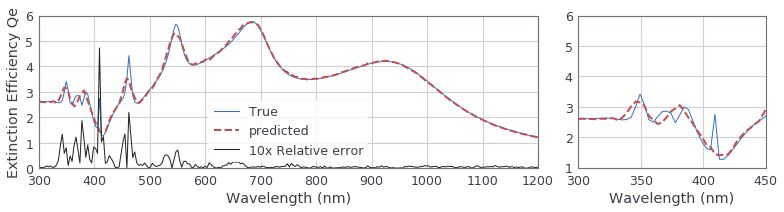

In [4]:
from matplotlib import gridspec
import snlay as snlay
#here we test edge cases where failure happens
#size = np.array([70, 60, 50, 40, 30, 20, 10, 10])
#size = np.array([70, 70, 70, 70, 70, 70, 70, 70])
#size = np.array([30, 30, 30, 30, 30, 30, 30, 30])

#size = np.array([65, 65, 65, 65, 55, 65, 35, 65])
#size = np.array([65, 35, 45, 35, 45, 35, 45, 35])

size = np.random.randint(30, 71, 8)
mats = np.array([3, 4, 3, 4, 3, 4, 3, 4])
spec_ac = snlay.calc_spectrum(size, mats, lams)

print(size)


size = (size - 50.0)/20.0



spec = model.predict(np.expand_dims(size, axis = 0))

spec = np.ravel(spec)


fig1 = plt.figure(figsize=(11,3))
gs = gridspec.GridSpec(1, 2, width_ratios=[8, 3]) 

ax = plt.subplot(gs[0])
#ax = fig1.add_subplot(1,2,1)
#ax.set_title('silica coated gold')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Extinction Efficiency Qe')
ax.set_ylim((0, 6))
ax.set_xlim((300, 1200))
plt.plot(lams, spec_ac,'b', linewidth=1, label='True')
plt.plot(lams, spec, 'r--', linewidth=2, label='predicted')
plt.plot(lams, 10*np.abs(spec_ac - spec)/spec_ac,'k', linewidth=1, label='10x Relative error')
ax.legend(loc='best')

ax2 = plt.subplot(gs[1])
#fig2 = plt.figure(figsize=(3,3))
#ax2 = fig1.add_subplot(1,2,2)
#ax.set_title('silica coated gold')
ax2.set_xlabel('Wavelength (nm)')
#ax.set_ylabel('Extinction Efficiency Qe')
#ax2.set_ylim((2, 6))
ax2.set_xlim((300, 450))
plt.plot(lams, spec_ac,'b', linewidth=1, label='True')
plt.plot(lams, spec, 'r--', linewidth=2, label='predicted')
#plt.plot(lams, 10*np.abs(spec_ac - spec)/spec_ac,'b', linewidth=1, label='10x Relative error')
#ax.legend(loc='best')



plt.tight_layout()
plt.savefig('grid_figure.pdf')






In [5]:
size.shape

(8,)

In [6]:
# loop for hundred runs 
import snlay as snlay
import time

mats = np.array([3, 4, 3, 4, 3, 4, 3, 4])
#spec_ac = snlay.calc_spectrum(size, mats, lams)

reps = 100


start = time.time()
for ind in np.arange(reps):
    size = np.random.randint(30, 71, 8)
    #size = np.random.randint(30, 71, (1,8))
    #spec_ac = snlay.calc_spectrum(size, mats, lams)
    size = (size - 50.0)/20.0
    size = np.expand_dims(size, axis=0)
    spec = model.predict(size)
    #data_iter = mx.io.NDArrayIter(size, None, 1)
    #result = mod.predict(size)
    #result = result.asnumpy()

    
end = time.time()
print(1000*(end - start)/reps)   
    


result



1.829695701599121


NameError: name 'result' is not defined

### Inverse scattering 

In [ ]:
# from keras.models import Model
# from keras.layers import Input, Add, AveragePooling1D, MaxPooling1D, Concatenate



# a = Input(shape=(1,))
# first = Dense(8, input_dim=1, kernel_initializer='normal', activation='linear', 
#               name='dummy', use_bias=False)(a)
# last = model(first)
# #last = Dense(256, kernel_initializer='normal')(first)
# #last = Flatten()(first)

# model_d = Model(inputs=a, outputs=last)
# model_d.compile(loss=naive_percent_loss, optimizer='nadam', metrics=[calc_mre_K], context=['gpu(0)'])

model_d = Sequential()
model_d.add(Dense(8, input_dim=1, kernel_initializer='normal', activation='linear', 
                    name='dummy', use_bias=False))

for layer in model.layers[1:]:
    model_d.add(layer)

# for layer in model_d.layers[1:]:
#     layer.trainable = False

# for ind in range(1,len(model_d.layers)):
#     model_d.layers[ind].set_weights(model.layers[ind-1].get_weights())

model_d.compile(loss=naive_percent_loss, optimizer='adam')    
    
    
model_d.summary()


for layer in model.layers[1:]:
    print(layer)






# # # let us create a target spectrum first
# import snlay as snlay
# #size = np.array([60, 65, 65, 65, 35, 35, 35, 35])
# size = np.random.randint(30,70,8)
# mats = np.array([3, 4, 3, 4, 3, 4, 3, 4])
# target = snlay.calc_spectrum(size, mats, lams)

# print(size)

# # #do the training here
# xd_t = np.ones((1,1))
# yd_t = target.reshape(1,250)





# history = model_d.fit(xd_t, yd_t,
#                     batch_size=1,
#                     epochs=5000, 
#                     verbose=0)

# # #here is the final result
# size_out = model_d.get_layer('dummy')
# wts = size_out.get_weights()
# wts = np.array(wts).ravel()
# size_res= 0.5*wts*(size_max - size_min) + size_av
# size_res_rounded = np.round(size_res)

# spec_zer = model_d.predict(xd_t).ravel()
# achieved = snlay.calc_spectrum(size_res_rounded, mats, lams)


# fig1 = plt.figure(figsize=(22,5))
# ax = fig1.add_subplot(1,1,1)
# #plt.plot(lams, spec_zer, label='new model')
# plt.plot(lams, target, linewidth=2, label='target')
# plt.plot(lams, achieved, '--', linewidth=3, label='achieved')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# print(size_res_rounded)


In [ ]:
from keras.models import Model
from keras.layers import Input, Add, AveragePooling1D, MaxPooling1D, Concatenate

a = Input(shape=(8,))
first = Dense(256, kernel_initializer='normal')(a)
#first = Dense(128, kernel_initializer='normal')(first)
#first = BatchNormalization()(first)
first= Activation('relu')(first)

first = Reshape((256,1))(first)
#first = UpSampling1D(size = 2)(first)
first = Conv1D(filters=32, kernel_size=1, strides=1, padding='same', 
            kernel_initializer='normal', activation='relu')(first)
#first = UpSampling1D(size = 2)(first)




# first_1 = Conv1D(filters=4, kernel_size=1, strides=1, padding='same', 
#             kernel_initializer='normal')(first)
# first_1 = Activation('relu')(first_1)
# first_1 = Conv1D(filters=8, kernel_size=3, strides=1, padding='same', 
#             kernel_initializer='normal')(first_1)
first_2 = Conv1D(filters=4, kernel_size=1, strides=1, padding='same', 
            kernel_initializer='normal')(first)
#first_2 = Activation('relu')(first_2)
first_2 = Conv1D(filters=8, kernel_size=3, strides=1, padding='same', 
            kernel_initializer='normal')(first_2)
first_3 = Conv1D(filters=4, kernel_size=1, strides=1, padding='same', 
            kernel_initializer='normal')(first)
first_3 = Activation('relu')(first_3)
first_3 = Conv1D(filters=8, kernel_size=5, strides=1, padding='same', 
            kernel_initializer='normal')(first_3)
first_4 = Conv1D(filters=16, kernel_size=1, strides=1, padding='same', 
            kernel_initializer='normal')(first)
list_of_tensors = [first_2, first_3, first_4]
conc = Concatenate()(list_of_tensors)
first = Add()([first, conc])
first= Activation('relu')(first)



# first_1 = Conv1D(filters=4, kernel_size=1, strides=1, padding='same', 
#             kernel_initializer='normal')(first)
# first_1 = Activation('relu')(first_1)
# first_1 = Conv1D(filters=8, kernel_size=3, strides=1, padding='same', 
#             kernel_initializer='normal')(first_1)
first_2 = Conv1D(filters=4, kernel_size=1, strides=1, padding='same', 
            kernel_initializer='normal')(first)
#first_2 = Activation('relu')(first_2)
first_2 = Conv1D(filters=8, kernel_size=3, strides=1, padding='same', 
            kernel_initializer='normal')(first_2)
first_3 = Conv1D(filters=4, kernel_size=1, strides=1, padding='same', 
            kernel_initializer='normal')(first)
first_3 = Activation('relu')(first_3)
first_3 = Conv1D(filters=8, kernel_size=5, strides=1, padding='same', 
            kernel_initializer='normal')(first_3)
first_4 = Conv1D(filters=16, kernel_size=1, strides=1, padding='same', 
            kernel_initializer='normal')(first)
list_of_tensors = [first_2, first_3, first_4]
conc = Concatenate()(list_of_tensors)
first = Add()([first, conc])
first= Activation('relu')(first)




# first_1 = Conv1D(filters=4, kernel_size=1, strides=1, padding='same', 
#             kernel_initializer='normal')(first)
# first_1 = Activation('relu')(first_1)
# first_1 = Conv1D(filters=8, kernel_size=3, strides=1, padding='same', 
#             kernel_initializer='normal')(first_1)
first_2 = Conv1D(filters=4, kernel_size=1, strides=1, padding='same', 
            kernel_initializer='normal')(first)
#first_2 = Activation('relu')(first_2)
first_2 = Conv1D(filters=8, kernel_size=3, strides=1, padding='same', 
            kernel_initializer='normal')(first_2)
first_3 = Conv1D(filters=4, kernel_size=1, strides=1, padding='same', 
            kernel_initializer='normal')(first)
first_3 = Activation('relu')(first_3)
first_3 = Conv1D(filters=8, kernel_size=5, strides=1, padding='same', 
            kernel_initializer='normal')(first_3)
first_4 = Conv1D(filters=16, kernel_size=1, strides=1, padding='same', 
            kernel_initializer='normal')(first)
list_of_tensors = [first_2, first_3, first_4]
conc = Concatenate()(list_of_tensors)
first = Add()([first, conc])
first= Activation('relu')(first)

# first_1 = Conv1D(filters=4, kernel_size=1, strides=1, padding='same', 
#             kernel_initializer='normal')(first)
# first_1 = Activation('relu')(first_1)
# first_1 = Conv1D(filters=8, kernel_size=3, strides=1, padding='same', 
#             kernel_initializer='normal')(first_1)
first_2 = Conv1D(filters=4, kernel_size=1, strides=1, padding='same', 
            kernel_initializer='normal')(first)
#first_2 = Activation('relu')(first_2)
first_2 = Conv1D(filters=8, kernel_size=3, strides=1, padding='same', 
            kernel_initializer='normal')(first_2)
first_3 = Conv1D(filters=4, kernel_size=1, strides=1, padding='same', 
            kernel_initializer='normal')(first)
first_3 = Activation('relu')(first_3)
first_3 = Conv1D(filters=8, kernel_size=5, strides=1, padding='same', 
            kernel_initializer='normal')(first_3)
first_4 = Conv1D(filters=16, kernel_size=1, strides=1, padding='same', 
            kernel_initializer='normal')(first)
list_of_tensors = [first_2, first_3, first_4]
conc = Concatenate()(list_of_tensors)
first = Add()([first, conc])
first= Activation('relu')(first)





first = Reshape((32,256))(first)
first = MaxPooling1D(pool_size=32, strides=None, padding='same')(first)
last = Flatten()(first)

model = Model(inputs=a, outputs=last)
model.compile(loss=naive_percent_loss, optimizer='nadam', metrics=[calc_mre_K], context=['gpu(0)'])

#model.summary()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model

#SVG(model_to_dot(model, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))


plot_model(model, show_shapes=False, show_layer_names=False,  to_file='model.png')
#plot_model(model, to_file='model.png', )

x_t, x_v, y_t, y_v = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
# model = naiveploss_mgpu_model()
# model.summary()   
history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=2000, 
                    verbose=1,
                    validation_data=(x_test, y_test))






### Model shipment

In [ ]:

    
from keras.models import load_model

#Creates a HDF5 file 'my_model.h5'
model.save('my_model.h5')

# Deletes the existing model
#del model  

# Returns a compiled model identical to the previous one
#model = load_model('my_model.h5')



In [ ]:

from keras.models import Model
from keras.layers import Input, Add, Lambda, Dense
import numpy as np


def dropper(x):
    ms = 4
    #print(x.shape)
    
   
    
    return x**2
# msk = np.array([1,1,1,1,0,0,0,0])


a = Input(shape=(1,))
b = Dense(8, input_dim=1, kernel_initializer='normal', activation='linear', 
                    name='dummy', use_bias=False)(a)
b = Lambda(dropper)(b)
b = Dense(256)(b)
# #b = Lambda()
# a = Lambda(dropper)(a)
# 

model = Model(inputs=a, outputs=b)

# model = Sequential()
# model.add(Dense(256, input_dim=8))
# #model.add(Lambda(lambda x: x**2))
# model.add(Lambda(dropper))
# model.add(Dense(256))



model.compile(loss=naive_percent_loss, optimizer='adam', metrics=[calc_mre_K])
#model.summary()

In [ ]:
2 +2 

In [ ]:
import matplotlib.pyplot as plt